In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cine_seg.npz


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Load data
data = np.load('/kaggle/input/cine_seg.npz',allow_pickle=True)
# print(data.files)

(256, 256) (256, 256)


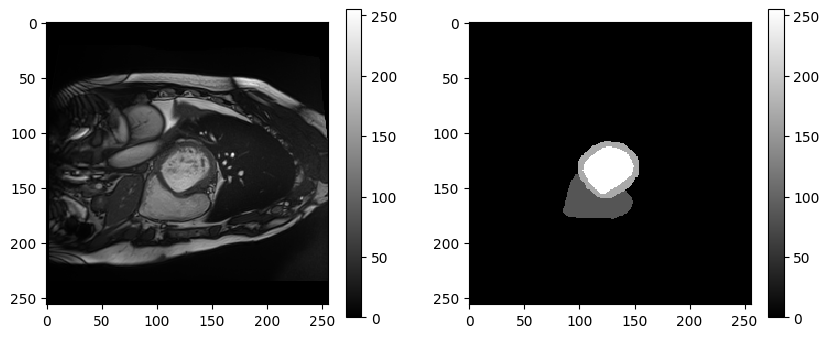

In [3]:
images = []
labels = []
for i in range (len(data.files)):
    images.append(data[data.files[i]][0])
    labels.append(data[data.files[i]][1])
# print(len(images),len(labels))
img = images[1]
gt = labels[1]
print(img.shape,gt.shape)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(gt)
plt.colorbar()
plt.show()
plt.close('all')

In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
images = images.astype(np.float32) / 255.0


In [6]:
unique_labels = np.unique(labels)
print(f'Unique label values before clipping: {unique_labels}')

Unique label values before clipping: [  0  85 170 255]


In [7]:
label_mapping = {0: 0, 85: 1, 170: 2, 255: 3}

# Apply mapping to labels
mapped_labels = np.vectorize(label_mapping.get)(labels)

# Check unique values in the labels after mapping
unique_labels = np.unique(mapped_labels)
print(f'Unique label values after mapping: {unique_labels}')

Unique label values after mapping: [0 1 2 3]


In [8]:
train_images, temp_images, train_labels, temp_labels = train_test_split(images, mapped_labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.6667, random_state=42)

# Convert to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_images = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)
test_labels = torch.tensor(test_labels, dtype=torch.long)
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape, test_labels.shape)

torch.Size([1258, 1, 256, 256]) torch.Size([1258, 256, 256])
torch.Size([179, 1, 256, 256]) torch.Size([179, 256, 256])
torch.Size([361, 1, 256, 256]) torch.Size([361, 256, 256])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomBrightnessContrast, Normalize
from albumentations.pytorch import ToTensorV2
import numpy as np
from sklearn.model_selection import train_test_split
def get_train_transforms():
    return Compose([
        HorizontalFlip(p=0.5),
        RandomRotate90(p=0.5),
        RandomBrightnessContrast(p=0.2),
        Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

def get_val_transforms():
    return Compose([
        Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

# 自定义数据集类
class CardiacDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        image = image.squeeze().numpy()
        mask = mask.squeeze().numpy()
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# 创建数据集实例
train_dataset = CardiacDataset(train_images, train_labels, transform=get_train_transforms())
val_dataset = CardiacDataset(val_images, val_labels, transform=get_val_transforms())
test_dataset = CardiacDataset(test_images, test_labels, transform=get_val_transforms())

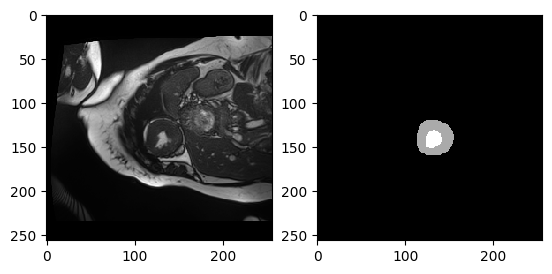

In [10]:
import matplotlib.pyplot as plt

# 打印和可视化增强后的样本
def visualize_augmentation(dataset, idx=0):
    image, mask = dataset[idx]
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.squeeze(), cmap='gray')
    ax[1].imshow(mask.squeeze(), cmap='gray')
    plt.show()

# 可视化增强后的训练样本
visualize_augmentation(train_dataset)


In [11]:
# train_dataset = TensorDataset(train_images, train_labels)
# val_dataset = TensorDataset(val_images, val_labels)
# test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, num_classes=4):
        super(UNet, self).__init__()
        
        # Down-sampling path
        self.enc1 = self.double_conv(1,16)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(32, 64)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(64,128)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(128, 256)

        # Up-sampling path
        self.upconv4 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec4 = self.double_conv(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec3 = self.double_conv(128,64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = self.double_conv(64, 32)
        self.upconv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = self.double_conv(32, 16)

        # Final output layer
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def center_crop_and_concat(self, x1, x2):
        """Crops x1 to the size of x2 and concatenates them"""
        H1, W1 = x1.shape[2], x1.shape[3]
        H2, W2 = x2.shape[2], x2.shape[3]
        if H1 != H2 or W1 != W2:
            x1 = F.pad(x1, [
                (W2-W1) // 2, # left
                (W2-W1) // 2, # right
                (H2-H1) // 2, # top
                (H2-H1) // 2  # bottom
            ])
        return torch.cat([x1, x2], dim=1)
    def forward(self, x):
        # Down-sampling path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Up-sampling path with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = self.center_crop_and_concat(enc4, dec4)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = self.center_crop_and_concat(enc3, dec3)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = self.center_crop_and_concat(enc2, dec2)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.center_crop_and_concat(enc1, dec1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)
    


# Initialize model, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_loss_history, val_loss_history

# Train the model
train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Train Loss: 1.1718, Val Loss: 0.3186
Epoch 2/50, Train Loss: 0.2550, Val Loss: 0.2034
Epoch 3/50, Train Loss: 0.1627, Val Loss: 0.1312
Epoch 4/50, Train Loss: 0.1282, Val Loss: 0.1211
Epoch 5/50, Train Loss: 0.1234, Val Loss: 0.1194
Epoch 6/50, Train Loss: 0.1187, Val Loss: 0.1149
Epoch 7/50, Train Loss: 0.1161, Val Loss: 0.1146
Epoch 8/50, Train Loss: 0.1160, Val Loss: 0.1141
Epoch 9/50, Train Loss: 0.1153, Val Loss: 0.1143
Epoch 10/50, Train Loss: 0.1155, Val Loss: 0.1140
Epoch 11/50, Train Loss: 0.1145, Val Loss: 0.1131
Epoch 12/50, Train Loss: 0.1141, Val Loss: 0.1139
Epoch 13/50, Train Loss: 0.1136, Val Loss: 0.1126
Epoch 14/50, Train Loss: 0.1134, Val Loss: 0.1121
Epoch 15/50, Train Loss: 0.1132, Val Loss: 0.1126
Epoch 16/50, Train Loss: 0.1129, Val Loss: 0.1122
Epoch 17/50, Train Loss: 0.1129, Val Loss: 0.1115
Epoch 18/50, Train Loss: 0.1125, Val Loss: 0.1116
Epoch 19/50, Train Loss: 0.1123, Val Loss: 0.1115
Epoch 20/50, Train Loss: 0.1129, Val Loss: 0.1121
Epoch 21/

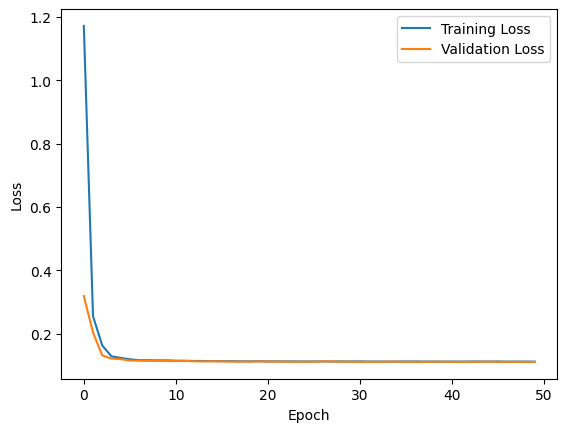

In [14]:
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



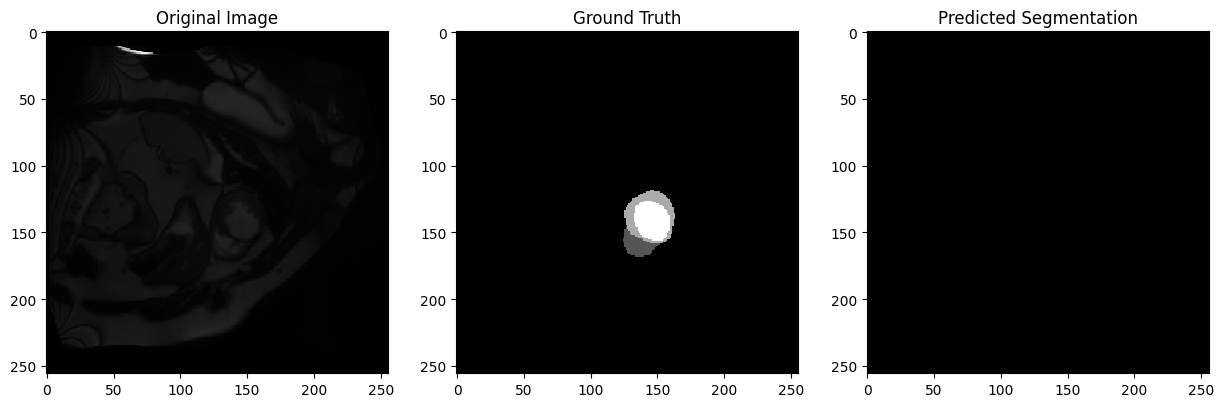

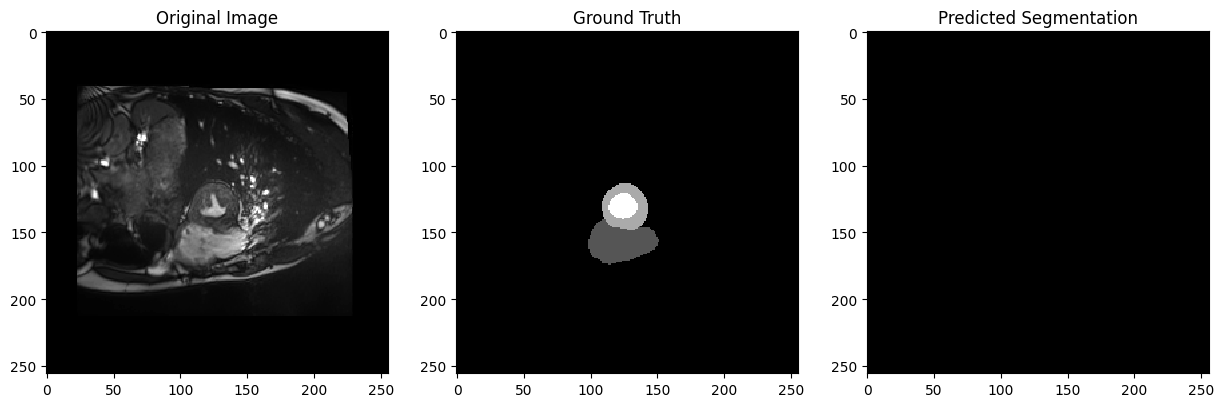

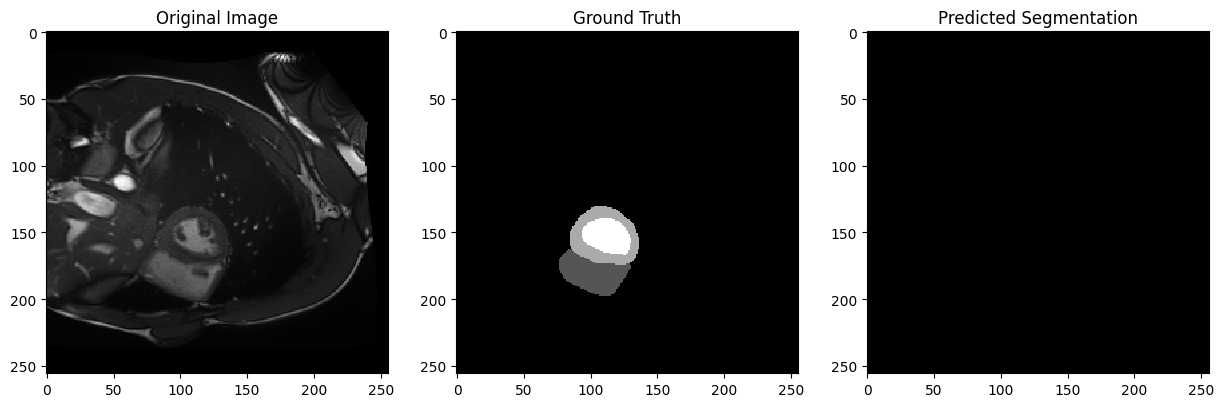

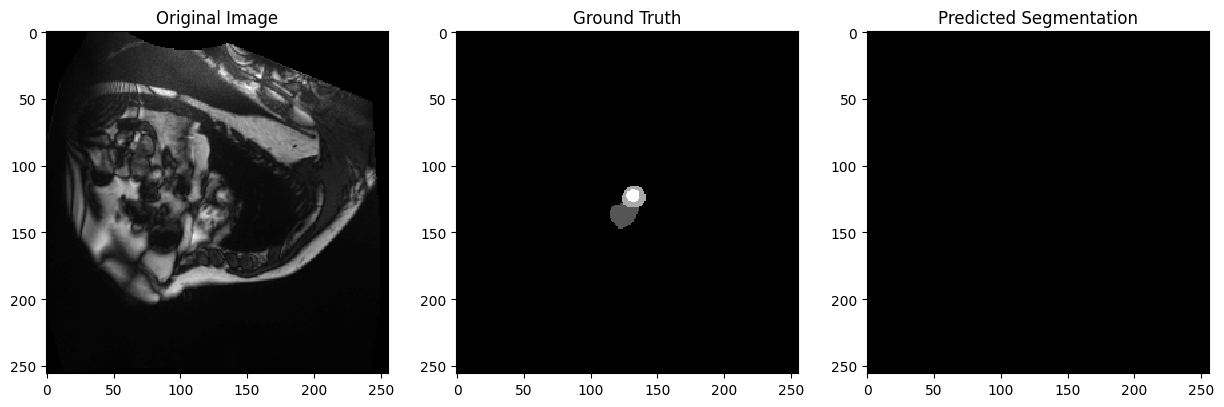

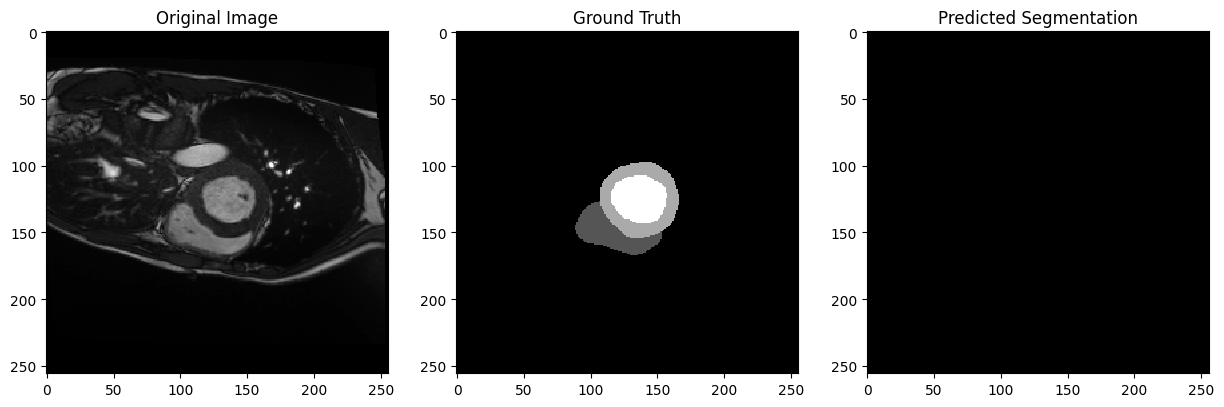

In [15]:
import matplotlib.pyplot as plt

def show_example_segmentation(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= 5:  
                break
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(images[0].cpu().squeeze(), cmap='gray')
            axes[0].set_title('Original Image')
            axes[1].imshow(labels[0].cpu().squeeze(), cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[2].imshow(preds[0].cpu().squeeze(), cmap='gray')
            axes[2].set_title('Predicted Segmentation')
            plt.show()

show_example_segmentation(model, test_loader, device)


In [16]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.item()

def calculate_dice_for_classes(preds, labels):
    dice_scores = {'LV': [], 'RV': [], 'MYO': []}
    
    for pred, label in zip(preds, labels):
        for class_idx, class_name in zip([1, 2, 3], ['LV', 'RV', 'MYO']):
            pred_class = (pred == class_idx).float()
            label_class = (label == class_idx).float()
            dice = dice_coefficient(pred_class, label_class)
            dice_scores[class_name].append(dice)
    
    return dice_scores


In [17]:
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    dice_scores = {'LV': [], 'RV': [], 'MYO': []}

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            batch_dice_scores = calculate_dice_for_classes(preds.cpu(), labels.cpu())
            for key in dice_scores:
                dice_scores[key].extend(batch_dice_scores[key])

    mean_dice = {key: np.mean(dice_scores[key]) for key in dice_scores}
    std_dice = {key: np.std(dice_scores[key]) for key in dice_scores}

    return mean_dice, std_dice

mean_dice, std_dice = evaluate_model(model, test_loader, device)

print("Dice Coefficient Mean and Standard Deviation:")
for key in mean_dice:
    print(f"{key} - Mean: {mean_dice[key]:.4f}, Std: {std_dice[key]:.4f}")


Dice Coefficient Mean and Standard Deviation:
LV - Mean: 0.2465, Std: 0.4310
RV - Mean: 0.0471, Std: 0.2118
MYO - Mean: 0.0637, Std: 0.2442


In [18]:
for key in mean_dice:
    print(f"Segmentation Performance for {key}:")
    print(f"Mean Dice Coefficient: {mean_dice[key]:.4f}")
    print(f"Standard Deviation of Dice Coefficient: {std_dice[key]:.4f}")

Segmentation Performance for LV:
Mean Dice Coefficient: 0.2465
Standard Deviation of Dice Coefficient: 0.4310
Segmentation Performance for RV:
Mean Dice Coefficient: 0.0471
Standard Deviation of Dice Coefficient: 0.2118
Segmentation Performance for MYO:
Mean Dice Coefficient: 0.0637
Standard Deviation of Dice Coefficient: 0.2442
